In [1]:
# import the MNIST Data
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
import seaborn as sns
from scipy import linalg as LA

np.random.seed(0)
np.set_printoptions(precision = 3,suppress =True)
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data

In [15]:
# get some of the STL data set
# Get the certain STL 10 Data
from skimage import util 
import warnings
warnings.filterwarnings("ignore")

def showimages(x,coloums=30,row=3,col=False):
    fig=plt.figure(figsize=(30, 3))
    columns = coloums; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if col: plt.imshow(np.squeeze(x[i-1]))
        else:   plt.imshow(np.squeeze(x[i-1]),cmap='gray')
        plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
        plt.grid(False)
    plt.show()

data_location = "../../Dataset/STL10/img/2/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))

image_resize_px = 64
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px,3))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index]),(image_resize_px,image_resize_px))

# print out the data shape and the max and min value
print('Train batch, min, max : ',train_batch.shape,train_batch.min((0,1,2)),train_batch.max((0,1,2)))

train_batch_bird = train_batch.copy()

data_location = "../../Dataset/STL10/img/3/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))

image_resize_px = 64
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px,3))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index]),(image_resize_px,image_resize_px))

# print out the data shape and the max and min value
print('Train batch, min, max : ',train_batch.shape,train_batch.min((0,1,2)),train_batch.max((0,1,2)))

train_batch_not_bird = train_batch.copy()

Train batch, min, max :  (500, 64, 64, 3) [0. 0. 0.] [1. 1. 1.]
Train batch, min, max :  (500, 64, 64, 3) [0. 0. 0.] [1. 1. 1.]


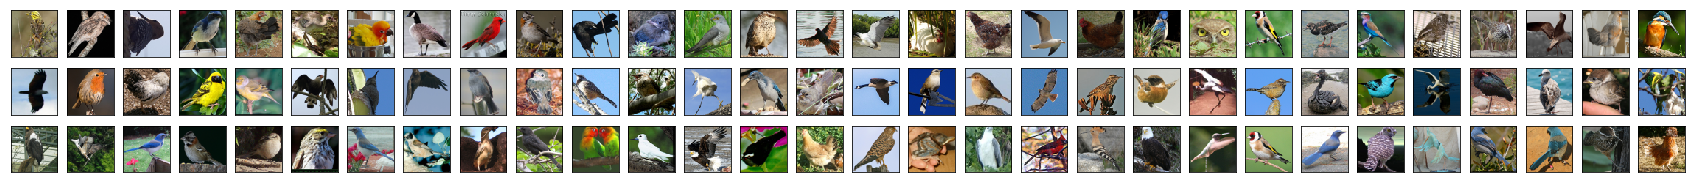

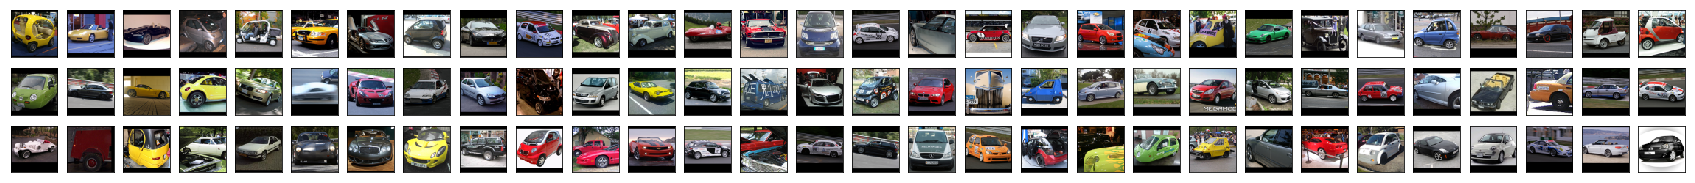

In [16]:
# show each class of images
showimages(train_batch_bird)
showimages(train_batch_not_bird)

In [54]:
# define the tf layers
def tf_tanh(x):      return tf.nn.tanh(x)
def d_tf_tanh(x):    return 1 - tf_tanh(x) ** 2
def tf_elu(x):       return tf.nn.elu(x)
def d_tf_elu(x):     return tf.cast(tf.greater_equal(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less(x,0),tf.float64) * x) + 1.0)
def tf_relu(x):      return tf.nn.relu(x)
def d_tf_relu(x):    return tf.cast(tf.greater_equal(x,0),tf.float64)
def tf_logcosh(x):   return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)
def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_exp(x):  
    one  = tf.exp( -( tf.square(x))/2)
    return x * one
def d_tf_exp(x):
    one  = tf.exp( -( tf.square(x))/2)
    two  = (1-tf.square(x)) * one
    return two

class CNN():

    def __init__(self,k,inc,out,stddev=0.5,which_reg=0.0,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        ) / batch_size
        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        )

        if self.which_reg == 0:
            grad = grad

        if self.which_reg == 0.5:
            grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)

        if self.which_reg == 1:
            grad = grad + lamda * tf.sign(self.w)

        if self.which_reg == 1.5:
            grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w

        if self.which_reg == 2:
            grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)

        if self.which_reg == 2.5:
            grad = grad + lamda * 2.0 * self.w

        if self.which_reg == 3:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)

        if self.which_reg == 4:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w
    
class FastICA_Layer():

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=1.0,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act
    
    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u)),matrix)
        return decor_matrx
    
    def getw(self): return self.w
    
    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer

    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_pass    = tf.matmul(tf.transpose(self.w),self.layer) 
        grad = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - self.layerDA[tf.newaxis,:] * self.w
        grad = self.sym_decorrelation(grad) 
        grad_w_score = grad
 
        update_w = []
        # ==== Correct Method of Weight Update ====
        #update_w.append(tf.assign(self.w,grad))

        # ==== Wrong (Adam) Method of Weight Update ====
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat  *learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle ))) 
        
        return grad_w_score,grad_pass,update_w
    
class zca_whiten_layer():

    def __init__(self): pass

    def feedforward(self,input,EPS=10e-5):
        self.input = input
        self.sigma = tf.matmul(tf.transpose(input),input) / input.shape[0].value
        self.eigenval,self.eigvector = tf.linalg.eigh(self.sigma)
        self.U = tf.matmul(tf.matmul(self.eigvector,tf.diag(1./ tf.sqrt(self.eigenval+EPS))),tf.transpose(self.eigvector))
        self.whiten = tf.matmul(input,self.U)
        return self.whiten

    def backprop(self,grad,EPS=10e-5):
        d_U = tf.matmul(tf.transpose(self.input),grad)
        
        # d_eig_value = self.eigvector.T.dot(d_U).dot(self.eigvector) * (-0.5) * np.diag(1. / (self.eigenval+EPS) ** 1.5)
        d_eig_value = tf.matmul(tf.matmul(tf.transpose(self.eigvector),d_U),self.eigvector) * (-0.5) * tf.diag(1./(self.eigenval+EPS) ** 1.5 )
        
        # d_eig_vector = d_U.dot( (np.diag(1. / np.sqrt(self.eigenval+EPS)).dot(self.eigvector.T)).T  ) + (self.eigvector.dot(np.diag(1. / np.sqrt(self.eigenval+EPS)))).dot(d_U)
        d_eig_vector = tf.matmul(d_U,tf.transpose(tf.matmul( tf.diag(1./ tf.sqrt(self.eigenval+EPS)), tf.transpose(self.eigvector)))) + \
                       tf.matmul(tf.transpose(d_U),tf.matmul(self.eigvector,tf.diag(1./ tf.sqrt(self.eigenval+EPS))))

        # E = np.ones((grad.shape[1],1)).dot(np.expand_dims(self.eigenval.T,0)) - 
        #     np.expand_dims(self.eigenval,1).dot(np.ones((1,grad.shape[1])))
        E = tf.matmul(tf.ones([grad.shape[1].value,1],dtype=tf.float64),tf.transpose(self.eigenval)[tf.newaxis,:]) - \
            tf.matmul(self.eigenval[:,tf.newaxis],tf.ones([1,grad.shape[1].value],dtype=tf.float64))

        # K_matrix = 1./(E + np.eye(grad.shape[1])) - np.eye(grad.shape[1])
        K_matrix = 1.0 /( E + tf.eye(grad.shape[1].value,dtype=tf.float64)) - tf.eye(grad.shape[1].value,dtype=tf.float64)

        # np.fill_diagonal(d_eig_value,0.0)
        tf.matrix_set_diag(d_eig_value, tf.zeros(shape=(d_eig_value.shape[0].value),dtype=tf.float64) )

        # d_sigma = self.eigvector.dot(
        #             K_matrix.T * (self.eigvector.T.dot(d_eig_vector)) + d_eig_value
        #             ).dot(self.eigvector.T)
        d_sigma = tf.matmul(tf.matmul(self.eigvector,
                    tf.transpose(K_matrix) * tf.matmul(tf.transpose(self.eigvector),d_eig_vector) + d_eig_value),
                    tf.transpose(self.eigvector))

        # d_x = grad.dot(self.U.T) + (2./grad.shape[0]) * self.input.dot(d_sigma) * 2
        d_x  = tf.matmul(grad,tf.transpose(self.U)) + (2.0/grad.shape[0].value) * tf.matmul(self.input,d_sigma) * 2

        return d_x
        
class tf_mean_layer():

    def __init__(self):
        pass

    def feedforward(self,input):
        self.mean = tf.reduce_mean(input,1)
        return input-self.mean[:,tf.newaxis]

    def backprop(self,grad):
        return grad * (1 + 1.0/grad.shape[0].value)

In [65]:
# start the whole batch training
num_iter = 200; learning_rate = 0.008; batch_size = 10; lamda=0.0
beta1,beta2,adam_e = 0.9,0.999,1e-8

c1 = CNN(3,3,3)
c2 = CNN(3,3,3)
c3 = CNN(3,3,3)
c4 = CNN(3,3,3)

mean= tf_mean_layer(); zca= zca_whiten_layer()
ica= FastICA_Layer(batch_size,batch_size,act=tf_exp,d_act=d_tf_exp)

In [66]:
# define graph
x = tf.placeholder(shape=[batch_size,64,64,3],dtype=tf.float64)

layer1 = c1.feedforward(x,     padding='VALID')
layer2 = c2.feedforward(layer1,padding='VALID')
layer3 = c3.feedforward(layer2,padding='VALID')
layer4 = c4.feedforward(layer3,padding='VALID')

final_reshape = tf.reshape(layer4,[batch_size,-1])
mean_layer    = mean.feedforward(final_reshape)
zca_layer     = tf.transpose(zca.feedforward(tf.transpose(mean_layer)))
fast_ica      = ica.feedforward(zca_layer)

grad_score,grad_ica,grad_ica_up = ica.backprop_ica()
grad_zca         = tf.transpose(zca.backprop(tf.transpose(grad_ica)))
grad_mean        = mean.backprop(grad_zca)
grad_zca_reshape = tf.reshape (grad_mean,[batch_size,56,56,3])

grad4,grad4_up = c4.backprop(grad_zca_reshape,padding='VALID')
grad3,grad3_up = c3.backprop(grad4,padding='VALID')
grad2,grad2_up = c2.backprop(grad3,padding='VALID')
grad1,grad1_up = c1.backprop(grad2,padding='VALID')

grad_update    = grad_ica_up + grad4_up + grad3_up + grad2_up + grad1_up

In [ ]:
# train the model adam approach
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_data_mini = train_batch[:90,:,:,:]; print(train_data_mini.shape)

for iter in range(num_iter):
    
    for current_data_index in range(0,len(train_data_mini),batch_size):
        current_data = train_data_mini[current_data_index:current_data_index+batch_size,:,:,:]
        sess_results = sess.run([grad_score,grad_update],feed_dict={x:current_data})
        sys.stdout.write('\r'+str(iter) + "  : "+str(sess_results[0].mean())); sys.stdout.flush()
        train_data_mini = shuffle(train_data_mini)        
    if iter % 50 == 0: print('\n---------------')


(90, 64, 64, 3)
0  : 8.706538279570908e-06
---------------
1  : 0.0035500700701735187

In [ ]:
# view the results for batch
train_data_mini  = shuffle(train_data_mini)
all_data_results = sess.run(fast_ica,feed_dict={x:train_data_mini[:batch_size,:,:,:] }).reshape((batch_size,64,64,3))
for current_data_index in range(batch_size,len(train_data_mini),batch_size):
    current_data = train_data_mini[current_data_index:current_data_index+batch_size,:,:,:]
    sess_results = sess.run(fast_ica,feed_dict={x:current_data}).reshape((batch_size,64,64,3))
    all_data_results = np.vstack((all_data_results,sess_results))

all_data_results[:,:,:,0]    = (all_data_results[:,:,:,0] - all_data_results[:,:,:,0].min()) /(all_data_results[:,:,:,0].max() - all_data_results[:,:,:,0].min() + 1e-8)
all_data_results[:,:,:,1]    = (all_data_results[:,:,:,1] - all_data_results[:,:,:,1].min()) /(all_data_results[:,:,:,1].max() - all_data_results[:,:,:,1].min() + 1e-8)
all_data_results[:,:,:,2]    = (all_data_results[:,:,:,2] - all_data_results[:,:,:,2].min()) /(all_data_results[:,:,:,2].max() - all_data_results[:,:,:,2].min() + 1e-8)
showimages(all_data_results,col=True)

temp           = all_data_results.reshape((90,-1))
temp_cen       = temp - temp.mean(1)[:,None]
covariance_mat = temp_cen @ temp_cen.T / (temp_all.shape[1])
temp_cen_std   = temp_cen / temp_cen.std(1)[:,None]
correlation_mat= temp_cen_std @ temp_cen_std.T / (temp_cen_std.shape[1])

sns.set(font_scale=3.)
plt.figure(figsize=(40,10))
plt.subplot(141); sns.heatmap(covariance_mat);   plt.title('My Covariance Matrix',fontsize=30);
plt.subplot(142); sns.heatmap(correlation_mat,vmin=-0.5);  plt.title('My Correlation Matrix',fontsize=30);

plt.subplot(143); sns.heatmap(np.cov(temp));       plt.title('Numpy Covariance Matrix',fontsize=30);
plt.subplot(144); sns.heatmap(np.corrcoef(temp),vmin=-0.5 ); plt.title('Numpy Correlation Matrix',fontsize=30);
plt.show()

In [ ]:
# start the ICA 1. view
dis_all = np.hstack((dis1,dis2))
mix_matrix = np.array([[1,0.5],[1,1]])
dis_mixed = dis_all @ mix_matrix
plt.scatter(dis_mixed[:,0],dis_mixed[:,1]);plt.show()

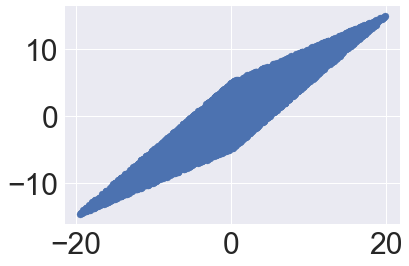

In [8]:
# 2. Subtract the mean
dis_mixed_cen = dis_mixed - dis_mixed.mean(0)
plt.scatter(dis_mixed_cen[:,0],dis_mixed_cen[:,1]);plt.show()

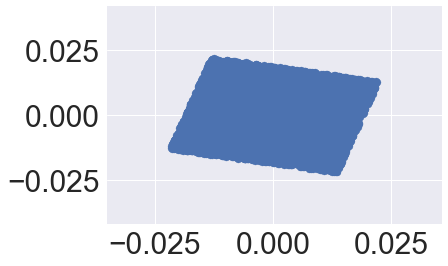

In [9]:
# perform zca whitening
cov = np.dot(dis_mixed_cen.T, dis_mixed_cen)
#   d = (lambda1, lambda2, ..., lambdaN)
d, E = np.linalg.eigh(cov)
#   D = diag(d) ^ (-1/2)
D = np.diag(1. / np.sqrt(d + 10e-5))
#   W_zca = E * D * E.T
W = np.dot(np.dot(E, D), E.T)
X_white = np.dot(dis_mixed_cen, W)
plt.scatter(X_white[:,0],X_white[:,1]);plt.show()

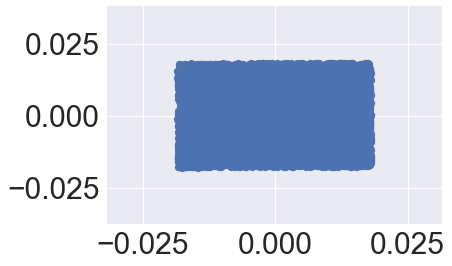

In [10]:
# manually perform ICA on the given data -> A Fast Fixed-Point Algorithm ICA
def _cube(x):
    return x ** 3, (3 * x ** 2).mean(axis=0)

def _sym_decorrelation(W):
    """ Symmetric decorrelation
    i.e. W <- (W * W.T) ^{-1/2} * W
    """
    s, u = np.linalg.eigh(np.dot(W, W.T))
    # u (resp. s) contains the eigenvectors (resp. square roots of
    # the eigenvalues) of W * W.T
    return np.dot(np.dot(u * (1. / np.sqrt(s)), u.T), W)

np.random.seed(40)
# 20 - good choice 
# 40 - good choice
unmixing_matrix = _sym_decorrelation(np.random.randn(2,2))

all_w1_values = []
for _ in range(100):
    gwtx, g_wtx = _cube(X_white @ unmixing_matrix  )
    W1 = _sym_decorrelation(np.dot(gwtx.T, X_white) / X_white.shape[1]   - g_wtx[:,np.newaxis]  * unmixing_matrix)
    lim = max(abs(abs(np.diag(np.dot(W1, W.T))) - 1))
    all_w1_values.append(lim.mean())
    unmixing_matrix = W1
        
final = X_white @ unmixing_matrix
plt.scatter(final[:,0],final[:,1]);plt.show()

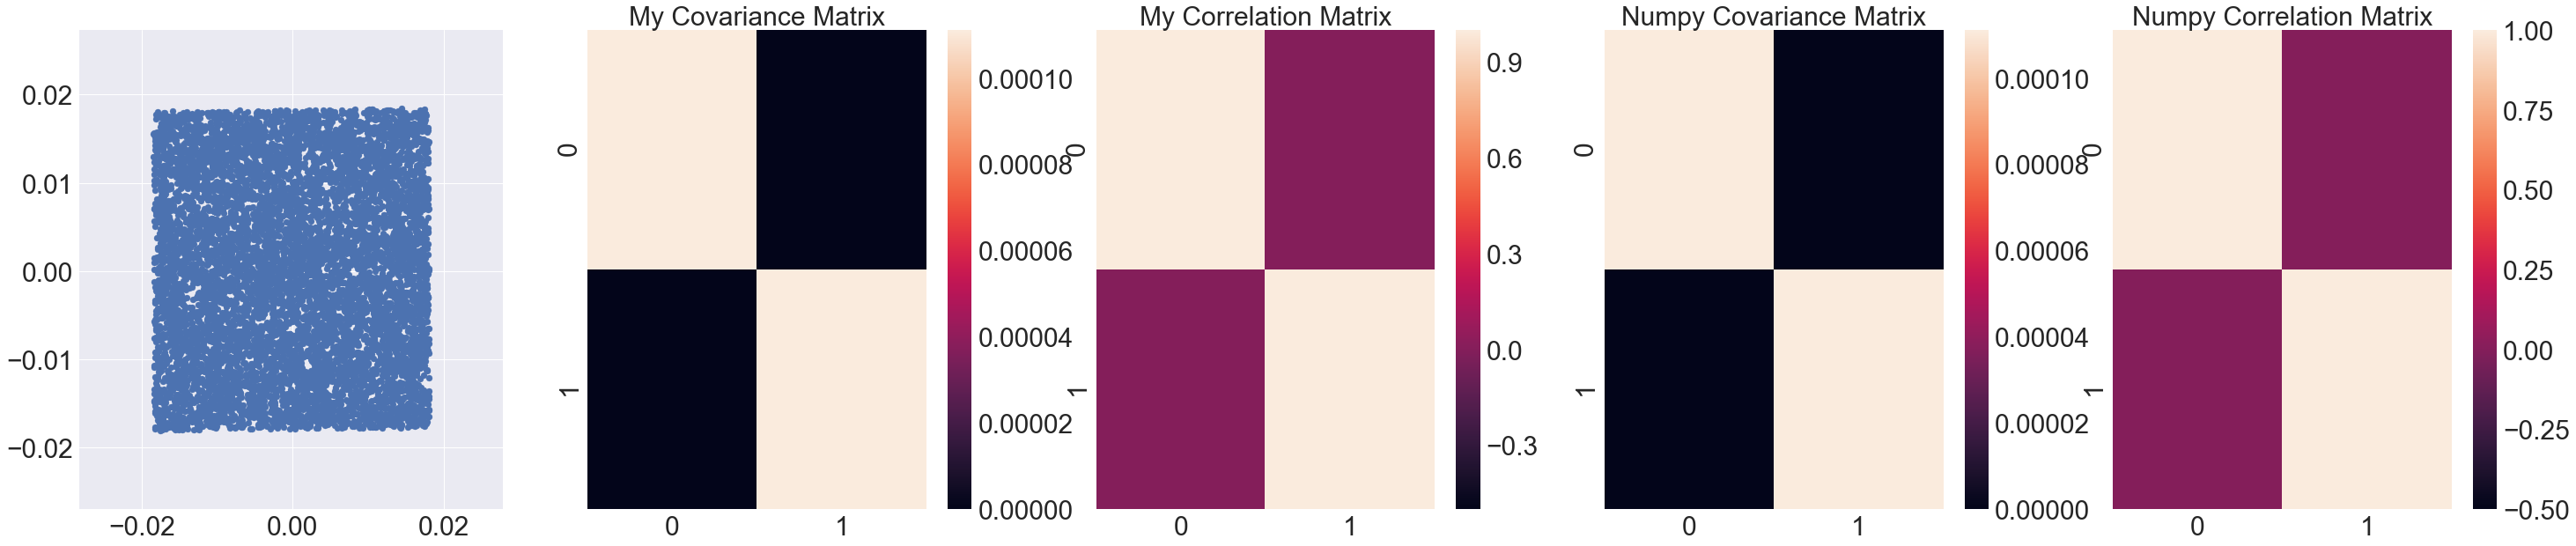

In [11]:
# view the distrbution and the covariance 
plt.figure(figsize=(50,10))
plt.subplot(151);  plt.scatter(final[:,0],final[:,1])

dis_all = final
dis_all = (dis_all - dis_all.mean(0))
covariance_mat = dis_all.T @ dis_all / (dis_all.shape[0])

dis_all = dis_all / dis_all.std(0)
correlation_mat= dis_all.T @ dis_all / (dis_all.shape[0])
sns.set(font_scale=3.)
plt.subplot(152); sns.heatmap(covariance_mat);   plt.title('My Covariance Matrix',fontsize=30);
plt.subplot(153); sns.heatmap(correlation_mat,vmin=-0.5);  plt.title('My Correlation Matrix',fontsize=30);

plt.subplot(154); sns.heatmap(np.cov(final.T));       plt.title('Numpy Covariance Matrix',fontsize=30);
plt.subplot(155); sns.heatmap(np.corrcoef(final.T),vmin=-0.5 ); plt.title('Numpy Correlation Matrix',fontsize=30);
plt.show()

In [52]:
# start the batch training 
num_iter = 200; learning_rate = 0.008; batch_size = 90; lamda=0.0
beta1,beta2,adam_e = 0.9,0.999,1e-8
l1 = CNN(3,3,3)
l2 = CNN(3,3,3)
l3 = CNN(3,3,3)
l4 = CNN(3,3,3)
mean= tf_mean_layer(); zca= zca_whiten_layer()
ica= FastICA_Layer(batch_size,batch_size,act=tf_exp,d_act=d_tf_exp)

In [53]:
# define graph
x = tf.placeholder(shape=[batch_size,64,64,3],dtype=tf.float64)

layer1 = l1.feedforward(x,     padding='SAME')
layer2 = l2.feedforward(layer1,padding='SAME')
layer3 = l3.feedforward(layer2,padding='SAME')
layer4 = l4.feedforward(layer3,padding='SAME')

final_reshape = tf.reshape(layer4,[batch_size,-1])
mean_layer    = mean.feedforward(final_reshape)
zca_layer     = tf.transpose(zca.feedforward(tf.transpose(mean_layer)))
fast_ica      = ica.feedforward(zca_layer)

grad_score,grad_ica,grad_ica_up = ica.backprop_ica()
grad_zca   = tf.transpose(zca.backprop(tf.transpose(grad_ica)))
grad_mean  = mean.backprop(grad_zca)
grad_zca_reshape = tf.reshape (grad_mean,[batch_size,64,64,3])

grad4,grad4_up = l4.backprop(grad_zca_reshape,padding='SAME')
grad3,grad3_up = l3.backprop(grad4,padding='SAME')
grad2,grad2_up = l2.backprop(grad3,padding='SAME')
grad1,grad1_up = l1.backprop(grad2,padding='SAME')
grad_update    = grad_ica_up + grad4_up + grad3_up + grad2_up + grad1_up

In [54]:
# train the batch
sess.run(tf.global_variables_initializer())
train_data_mini = train_batch[:90,:,:,:]
print(train_data_mini.shape)

for iter in range(num_iter):
    for current_data_index in range(0,len(train_data_mini),batch_size):
        current_data = train_data_mini[current_data_index:current_data_index+batch_size,:,:,:]
        sess_results = sess.run([grad_score,grad_update],feed_dict={x:current_data})
        sys.stdout.write('\r'+str(iter) + "  : "+str(sess_results[0].mean())); sys.stdout.flush()
    if iter % 50 == 0: print('\n---------------\n')
    train_data_mini = shuffle(train_data_mini)

(90, 64, 64, 3)
0  : -0.0005549275530072564
---------------

50  : -0.00070226354623068813
---------------

100  : -0.0006421836195483989
---------------

150  : -0.00073282341231054197
---------------

199  : 0.000617374948873303183

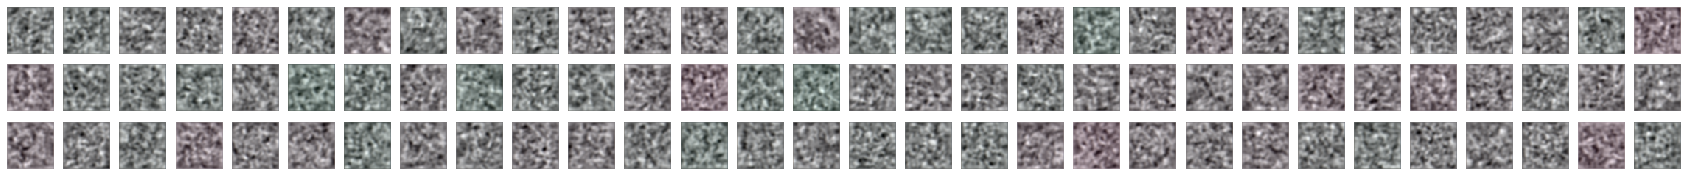

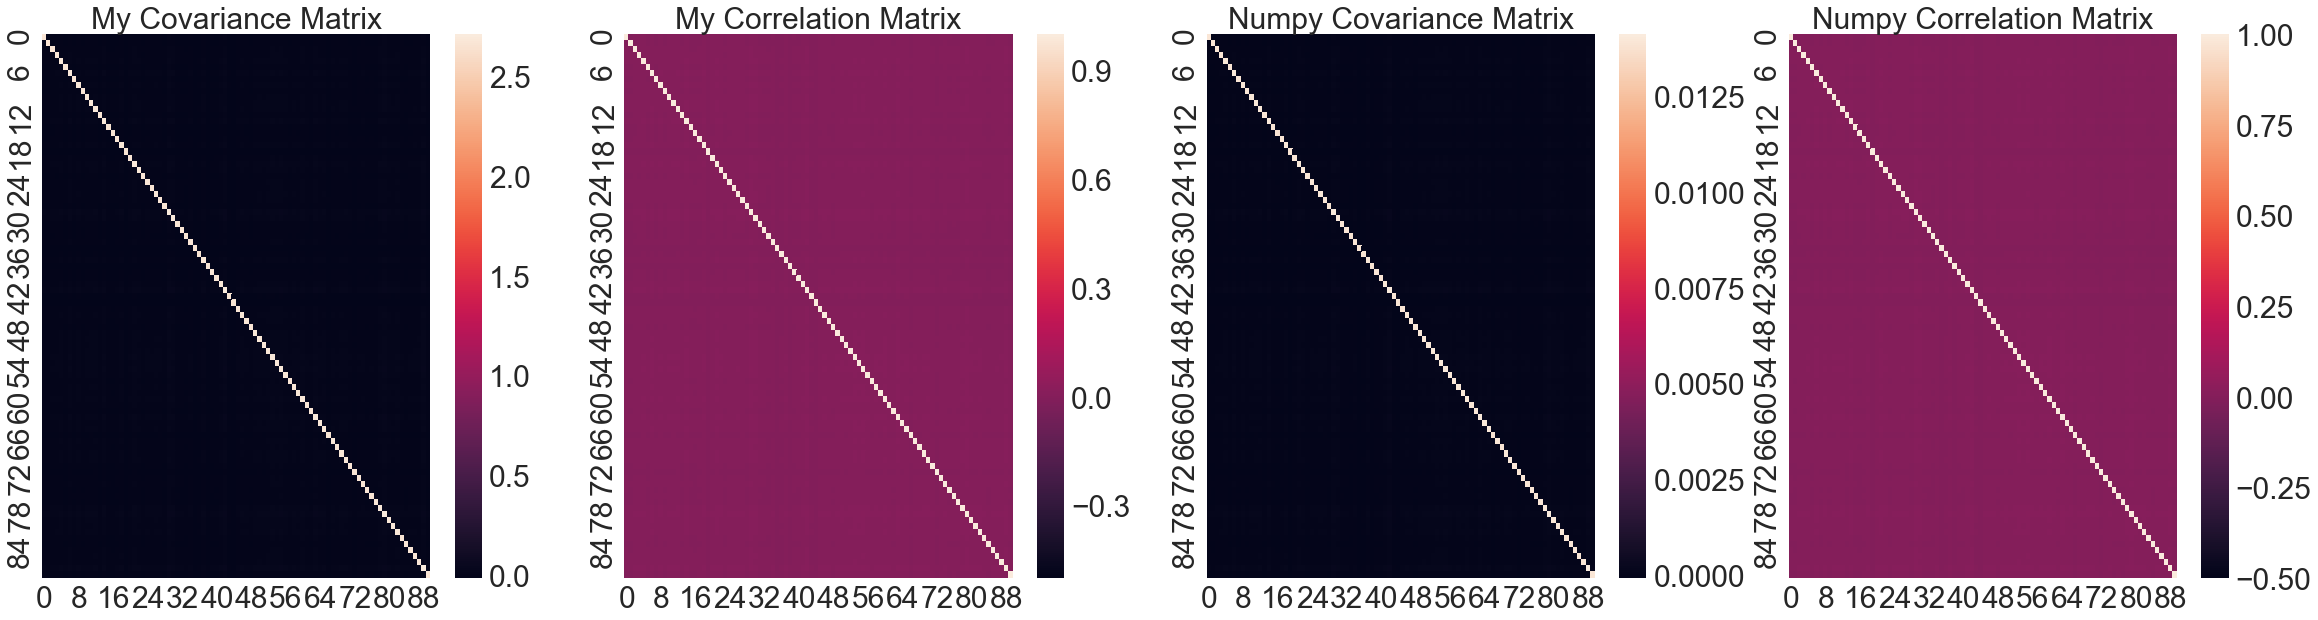

In [55]:
# view the results for batch
train_data_mini = shuffle(train_data_mini)
all_data_results = sess.run(fast_ica,feed_dict={x:train_data_mini[:batch_size,:,:,:] }).reshape((batch_size,64,64,3))
for current_data_index in range(batch_size,len(train_data_mini),batch_size):
    current_data = train_data_mini[current_data_index:current_data_index+batch_size,:,:,:]
    sess_results = sess.run(fast_ica,feed_dict={x:current_data}).reshape((batch_size,64,64,3))
    all_data_results = np.vstack((all_data_results,sess_results))

all_data_results[:,:,:,0]    = (all_data_results[:,:,:,0] - all_data_results[:,:,:,0].min()) /(all_data_results[:,:,:,0].max() - all_data_results[:,:,:,0].min() + 1e-8)
all_data_results[:,:,:,1]    = (all_data_results[:,:,:,1] - all_data_results[:,:,:,1].min()) /(all_data_results[:,:,:,1].max() - all_data_results[:,:,:,1].min() + 1e-8)
all_data_results[:,:,:,2]    = (all_data_results[:,:,:,2] - all_data_results[:,:,:,2].min()) /(all_data_results[:,:,:,2].max() - all_data_results[:,:,:,2].min() + 1e-8)
showimages(all_data_results,col=True)

temp = all_data_results.reshape((90,-1))
plt.figure(figsize=(40,10))
temp_cen = temp - temp.mean(1)[:,None]
covariance_mat = temp_cen @ temp_cen.T / (temp_all.shape[1])

temp_cen_std = temp_cen / temp_cen.std(1)[:,None]
correlation_mat= temp_cen_std @ temp_cen_std.T / (temp_cen_std.shape[1])
sns.set(font_scale=3.)
plt.subplot(141); sns.heatmap(covariance_mat);   plt.title('My Covariance Matrix',fontsize=30);
plt.subplot(142); sns.heatmap(correlation_mat,vmin=-0.5);  plt.title('My Correlation Matrix',fontsize=30);

plt.subplot(143); sns.heatmap(np.cov(temp));       plt.title('Numpy Covariance Matrix',fontsize=30);
plt.subplot(144); sns.heatmap(np.corrcoef(temp),vmin=-0.5 ); plt.title('Numpy Correlation Matrix',fontsize=30);
plt.show()

In [51]:
# # reference
# Holtz, Y. (2017). #92 Control color in seaborn heatmaps. The Python Graph Gallery. Retrieved 21 October 2018, from https://python-graph-gallery.com/92-control-color-in-seaborn-heatmaps/
# numpy.corrcoef — NumPy v1.15 Manual. (2018). Docs.scipy.org. Retrieved 21 October 2018, from https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.corrcoef.html
# numpy.cov — NumPy v1.15 Manual. (2018). Docs.scipy.org. Retrieved 21 October 2018, from https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.cov.html#numpy.cov
# http://users.stat.umn.edu/~helwig/notes/datamat-Notes.(2018). Users.stat.umn.edu. Retrieved 21 October 2018, from http://users.stat.umn.edu/~helwig/notes/datamat-Notes.pdf
# Covariance Matrix . (2018). Stattrek.com. Retrieved 21 October 2018, from https://stattrek.com/matrix-algebra/covariance-matrix.aspx
# covariance?, H. (2018). How would you explain the difference between correlation and covariance?. Cross Validated. Retrieved 21 October 2018, from https://stats.stackexchange.com/questions/18082/how-would-you-explain-the-difference-between-correlation-and-covariance
# matplotlib, H. (2018). Hide axis values in matplotlib. Stack Overflow. Retrieved 21 October 2018, from https://stackoverflow.com/questions/37039685/hide-axis-values-in-matplotlib/37045694
# plots, H. (2018). Hiding axis text in matplotlib plots. Stack Overflow. Retrieved 21 October 2018, from https://stackoverflow.com/questions/2176424/hiding-axis-text-in-matplotlib-plots